**INSTALL THE REQUIREMENTS**

In [1]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn

**MOUNT GOOGLE DRIVE & IMPORT LIBRARIES**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


**LOAD TRAINED MODEL**

In [3]:
print("\n" + "="*50)
print("LOADING TRAINED MODEL FROM GOOGLE DRIVE")
print("="*50)

drive_path = "/content/drive/MyDrive/AG_News_Project"
model_path = f"{drive_path}/distilbert_ag_news_final"

print(f"\nLoading model from: {model_path}")
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.to(device)
print("✓ Model and tokenizer loaded successfully")



LOADING TRAINED MODEL FROM GOOGLE DRIVE

Loading model from: /content/drive/MyDrive/AG_News_Project/distilbert_ag_news_final
✓ Model and tokenizer loaded successfully


**LOAD TEST DATASET**

In [4]:
print("\n" + "="*50)
print("LOADING TEST DATASET")
print("="*50)

tokenized_test = load_from_disk(f"{drive_path}/tokenized_test")
print(f"✓ Loaded test set: {len(tokenized_test)} samples")


LOADING TEST DATASET
✓ Loaded test set: 7600 samples


**DEFINE METRICS FUNCTION**

In [5]:
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, and F1-score"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average='weighted'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

**CREATE THE TRAINER FOR EVALUATION**

In [6]:
print("\n" + "="*50)
print("SETTING UP EVALUATION")
print("="*50)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


SETTING UP EVALUATION


/tmp/ipython-input-1127556525.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


**EVALUAATE ON TEST SET**

In [7]:
print("\nEvaluating model on test set...")
print("This may take a few minutes...\n")

test_results = trainer.predict(tokenized_test)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)

print(f"\nAccuracy:  {test_results.metrics['test_accuracy']:.4f} ({test_results.metrics['test_accuracy']*100:.2f}%)")
print(f"Precision: {test_results.metrics['test_precision']:.4f}")
print(f"Recall:    {test_results.metrics['test_recall']:.4f}")
print(f"F1-Score:  {test_results.metrics['test_f1']:.4f}")

# ========== DETAILED CLASSIFICATION REPORT ==========
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)

predictions = np.argmax(test_results.predictions, axis=1)
labels = test_results.label_ids

label_names = ['World', 'Sports', 'Business', 'Sci/Tech']

print("\n" + classification_report(
    labels,
    predictions,
    target_names=label_names,
    digits=4
))


Evaluating model on test set...
This may take a few minutes...



/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muhamadmariorizki (muhamadmariorizki-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



TEST SET RESULTS

Accuracy:  0.9453 (94.53%)
Precision: 0.9454
Recall:    0.9453
F1-Score:  0.9453

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

       World     0.9581    0.9500    0.9540      1900
      Sports     0.9863    0.9879    0.9871      1900
    Business     0.9264    0.9079    0.9171      1900
    Sci/Tech     0.9108    0.9353    0.9229      1900

    accuracy                         0.9453      7600
   macro avg     0.9454    0.9453    0.9453      7600
weighted avg     0.9454    0.9453    0.9453      7600



**CONFUSSION MATRIX**


CONFUSION MATRIX

✓ Confusion matrix saved to: /content/drive/MyDrive/AG_News_Project/confusion_matrix.png


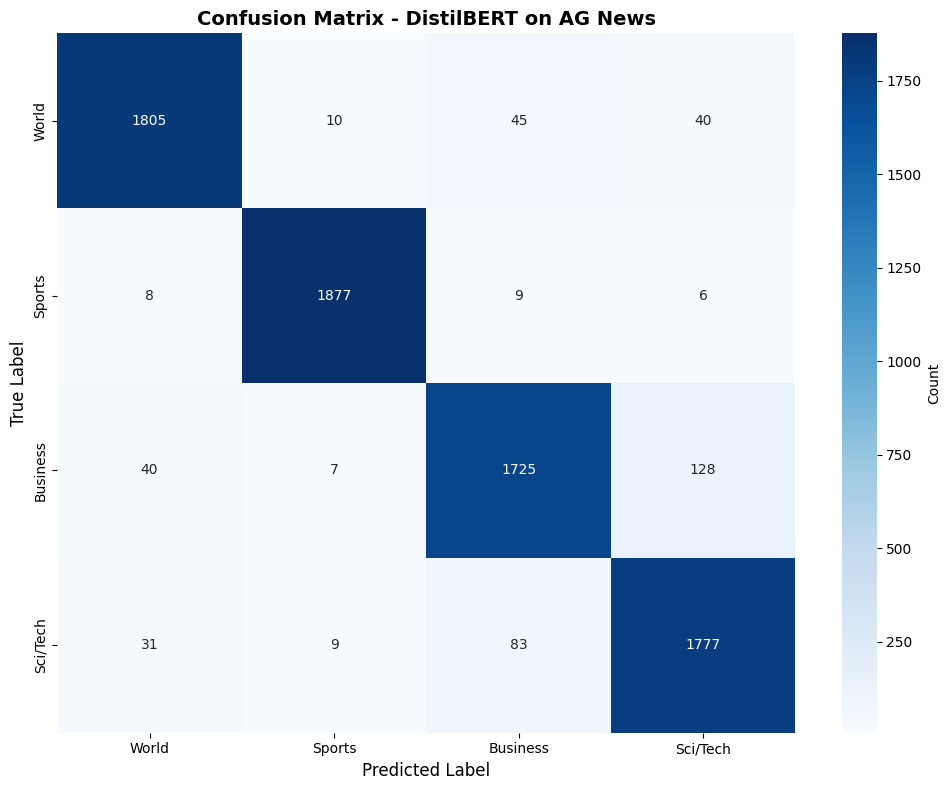

In [8]:
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - DistilBERT on AG News', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

# Save confusion matrix
cm_path = f"{drive_path}/confusion_matrix.png"
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Confusion matrix saved to: {cm_path}")
plt.show()

**PER CLASS ACCURACY**

In [9]:
print("\n" + "="*50)
print("PER-CLASS ACCURACY")
print("="*50)

per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, (name, acc) in enumerate(zip(label_names, per_class_accuracy)):
    print(f"{name:12s}: {acc:.4f} ({acc*100:.2f}%)")


PER-CLASS ACCURACY
World       : 0.9500 (95.00%)
Sports      : 0.9879 (98.79%)
Business    : 0.9079 (90.79%)
Sci/Tech    : 0.9353 (93.53%)


**ANALYZE MISSCLASSIFICATION**

In [11]:
print("\n" + "="*50)
print("SAMPLE MISCLASSIFICATIONS")
print("="*50)

# Load original test dataset to see text
original_test = load_from_disk(f"{drive_path}/ag_news_test")

# Find misclassified examples
misclassified_indices = np.where(predictions != labels)[0]

print(f"\nTotal misclassified: {len(misclassified_indices)} out of {len(labels)}")
print(f"Error rate: {len(misclassified_indices)/len(labels)*100:.2f}%\n")

# Show 5 misclassification examples
print("Showing first 5 misclassifications:\n")
for i, idx in enumerate(misclassified_indices[:5]):
    print(f"--- Example {i+1} ---")
    print(f"Text: {original_test[int(idx)]['text'][:200]}...")
    print(f"True label: {label_names[labels[idx]]}")
    print(f"Predicted: {label_names[predictions[idx]]}")
    print()


SAMPLE MISCLASSIFICATIONS

Total misclassified: 416 out of 7600
Error rate: 5.47%

Showing first 5 misclassifications:

--- Example 1 ---
Text: Some People Not Eligible to Get in on Google IPO. Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public b...
True label: Sci/Tech
Predicted: Business

--- Example 2 ---
Text: Venezuela Prepares for Chavez Recall Vote. Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market....
True label: World
Predicted: Business

--- Example 3 ---
Text: Intel to delay product aimed for high-definition TVs. SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously plann...
True label: Business
Predicted: Sci/Tech

--- Example 4 ---
Text: Surviving Biotech's Downturns. Charly Travers offers advice on withstanding the volat

**SAVE PREDICTION**

In [12]:
print("\n" + "="*50)
print("SAVING PREDICTIONS")
print("="*50)

# Create results dataframe
import pandas as pd

results_df = pd.DataFrame({
    'true_label': [label_names[l] for l in labels],
    'predicted_label': [label_names[p] for p in predictions],
    'correct': labels == predictions
})

results_path = f"{drive_path}/test_predictions.csv"
results_df.to_csv(results_path, index=False)
print(f"✓ Predictions saved to: {results_path}")


SAVING PREDICTIONS
✓ Predictions saved to: /content/drive/MyDrive/AG_News_Project/test_predictions.csv


**FINAL SUMMARY**

In [13]:
print("\n" + "="*50)
print("EVALUATION COMPLETE - SUMMARY")
print("="*50)

print(f"""
Model: DistilBERT (distilbert-base-uncased)
Dataset: AG News (4 classes)
Test Samples: {len(labels)}

Overall Performance:
  • Accuracy:  {test_results.metrics['test_accuracy']*100:.2f}%
  • Precision: {test_results.metrics['test_precision']:.4f}
  • Recall:    {test_results.metrics['test_recall']:.4f}
  • F1-Score:  {test_results.metrics['test_f1']:.4f}

Files Saved:
  • Model: {model_path}
  • Confusion Matrix: {cm_path}
  • Predictions: {results_path}
""")

print("="*50)
print("ALL TASKS COMPLETED!")
print("="*50)


EVALUATION COMPLETE - SUMMARY

Model: DistilBERT (distilbert-base-uncased)
Dataset: AG News (4 classes)
Test Samples: 7600

Overall Performance:
  • Accuracy:  94.53%
  • Precision: 0.9454
  • Recall:    0.9453
  • F1-Score:  0.9453

Files Saved:
  • Model: /content/drive/MyDrive/AG_News_Project/distilbert_ag_news_final
  • Confusion Matrix: /content/drive/MyDrive/AG_News_Project/confusion_matrix.png
  • Predictions: /content/drive/MyDrive/AG_News_Project/test_predictions.csv

ALL TASKS COMPLETED!
